# **Import modules**

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use("ggplot")
# %matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

# **Download data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Brain_MRI/

/content/drive/MyDrive/Brain_MRI


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mustafaosama22","key":"1709b943c6d92c28b8dce0f5e85b79e5"}'}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 99% 707M/714M [00:21<00:00, 56.5MB/s]
100% 714M/714M [00:21<00:00, 35.1MB/s]


In [ ]:
!unzip /content/drive/MyDrive/Brain_MRI/lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

# **Initializing important parameters**

In [ ]:
im_width = 256
im_height = 256
SEED = 22
EPOCHS = 100
BATCH_SIZE = 32
learning_rate = 1e-4

# **Loading images and masks paths**

## - prepare paths

In [ ]:
image_filenames_train = []

mask_files = glob('/content/drive/MyDrive/Brain_MRI/kaggle_3m/*/*_mask*')

for i in mask_files:
    image_filenames_train.append(i.replace('_mask', ''))

print(image_filenames_train[:10])
len(image_filenames_train)

['/content/drive/MyDrive/Brain_MRI/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif', '/content/drive/MyDrive/Brain_MRI/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif', '/content/drive/MyDrive/Brain_MRI/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14.tif', '/content/drive/MyDrive/Brain_MRI/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif', '/content/drive/MyDrive/Brain_MRI/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif', '/content/drive/MyDrive/Brain_MRI/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17.tif', '/content/drive/MyDrive/Brain_MRI/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_18.tif', '/content/drive/MyDrive/Brain_MRI/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_15.tif', '/content/drive/MyDrive/Brain_MRI/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_16.tif', '/content/drive/MyDrive/Brain_MRI/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_20.tif']


3929

## - Exploring images and masks

In [ ]:
def plot_from_img_path(rows, columns, list_img_path, list_mask_path):
    fig = plt.figure(figsize=(12, 12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.5)
    plt.show()

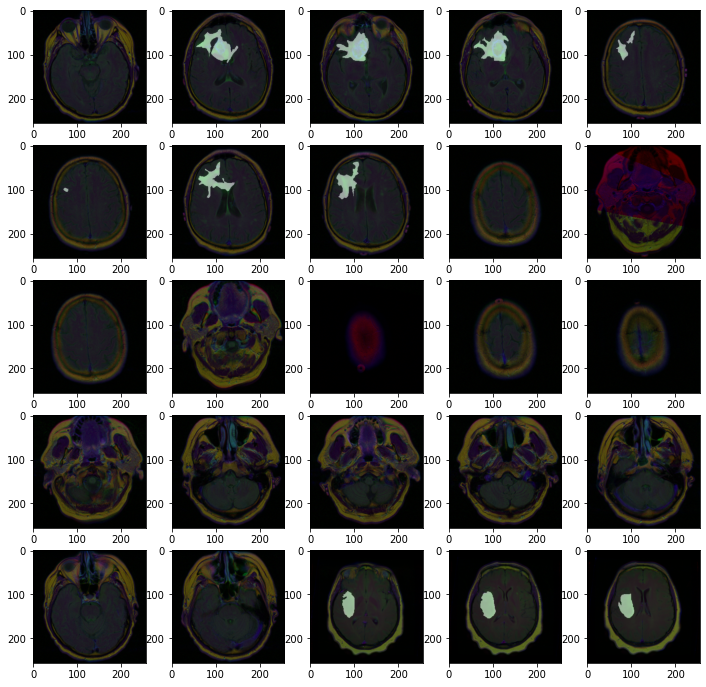

In [ ]:
plot_from_img_path(5, 5 , image_filenames_train, mask_files )

# **Prepare train, val and test data**

In [ ]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })

df_train, df_test = train_test_split(df, test_size=0.2)

# Further split this val and train
df_val, df_test = train_test_split(df_test, test_size=0.4)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(3143, 2)
(315, 2)
(471, 2)


# **Data genertator, data augmentation and adjust data**

In [ ]:
# After mask Normalization if the value is <= 0.5 then that Mask will be considered a complete black one and does not have any Tumor

def normalize_and_diagnose(img, mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return(img, mask)

In [ ]:
def data_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=SEED,
):
    """
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same

    """
    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filenames_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)
    
    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [ ]:
augmentation_param = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

train_gen = data_generator(df_train, BATCH_SIZE,
                                augmentation_param,
                                target_size=(im_height, im_width))
    
val_gen = data_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

# **Building UNET**

## - Import tensorflow dependencies

In [ ]:
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## - unet

In [ ]:
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # First DownConvolution / Encoder Leg will begin, so start with Conv2D
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    """ Now UpConvolution / Decoder Leg will begin, so start with Conv2DTranspose
    The gray arrows (in the above image) indicate the skip connections that concatenate the encoder feature map with the decoder, which helps the backward flow of gradients for improved training. """
    up6 = concatenate(
        [
            Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5),
            conv4
        ],
        axis=3
    )
    """ After every concatenation we again apply two consecutive regular convolutions so that the model can learn to assemble a more precise output """
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate(
        [
            Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6),
            conv3
        ],
        axis=3
    )
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate(
        [
            Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7),
            conv2
        ],
        axis=3
    )
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate(
        [
            Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8),
            conv1
        ],
        axis=3
    )
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

## - Build instance from the model

In [ ]:
model = unet()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

# **Define Loss and accuracy metrics**

In [ ]:
def dice_coefficients(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

In [ ]:
def dice_coefficients_loss(y_true, y_pred, smooth=100):
    return -dice_coefficients(y_true, y_pred, smooth)

In [ ]:
def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

# **Define Optimizer**

In [ ]:
decay_rate = learning_rate / EPOCHS

opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# **Training**

In [ ]:
model.compile(optimizer=opt, loss=dice_coefficients_loss, metrics=["binary_accuracy", iou, dice_coefficients])

In [ ]:
callbacks = [ModelCheckpoint('unet.hdf5', verbose=1, save_best_only=True)]

In [ ]:
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = val_gen,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 3143 validated image filenames.
Found 3143 validated image filenames.
Epoch 1/100
99/98 [==============================] - ETA: -1s - loss: -0.1324 - binary_accuracy: 0.9390 - iou: 0.0726 - dice_coefficients: 0.1327Found 471 validated image filenames.
Found 471 validated image filenames.

Epoch 1: val_loss improved from inf to -0.02267, saving model to unet.hdf5
98/98 [==============================] - 218s 2s/step - loss: -0.1324 - binary_accuracy: 0.9390 - iou: 0.0726 - dice_coefficients: 0.1327 - val_loss: -0.0227 - val_binary_accuracy: 0.9888 - val_iou: 0.0114 - val_dice_coefficients: 0.0225
Epoch 2/100
99/98 [==============================] - ETA: -1s - loss: -0.2204 - binary_accuracy: 0.9869 - iou: 0.1264 - dice_coefficients: 0.2218
Epoch 2: val_loss did not improve from -0.02267
98/98 [==============================] - 163s 2s/step - loss: -0.2204 - binary_accuracy: 0.9869 - iou: 0.1264 - dice_coefficients: 0.2218 - val_loss: -0.0199 - val_binary_accuracy: 0.9896 - val_iou

# **Load model**

In [ ]:
model = load_model('unet.hdf5', custom_objects={'dice_coefficients_loss': dice_coefficients_loss, 'iou': iou, 'dice_coefficients': dice_coefficients})

In [ ]:
test_gen = data_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height, im_width))

results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE )

print('Test Loss ', results[0])
print('Test IoU ', results[1])
print('Test Dice Coefficient ', results[2])

Found 315 validated image filenames.
Found 315 validated image filenames.
9/9 [==============================] - 522s 52s/step - loss: -0.9136 - binary_accuracy: 0.9982 - iou: 0.8428 - dice_coefficients: 0.9140
Test Loss  -0.9136123061180115
Test IoU  0.9982280135154724
Test Dice Coefficient  0.8428012728691101


# **Plotting Predicted Masks Segmentation results from the Test Image set**

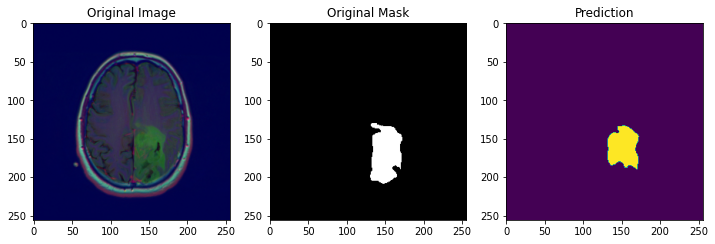

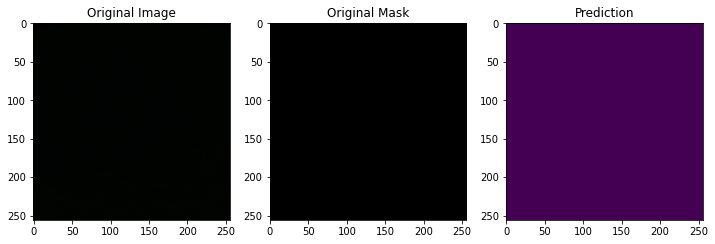

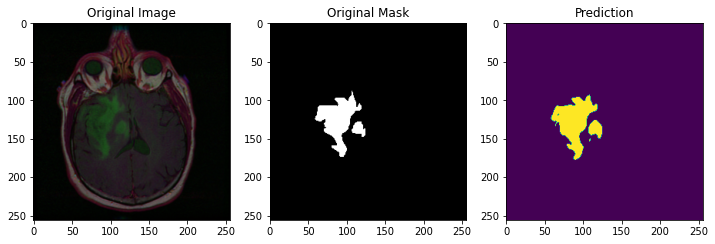

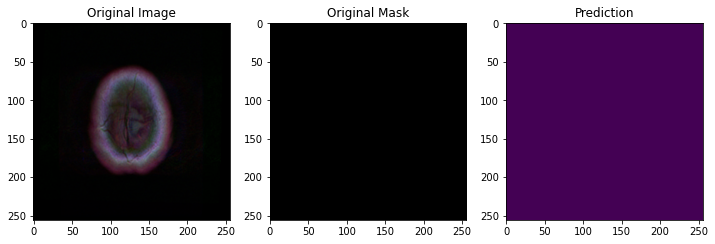

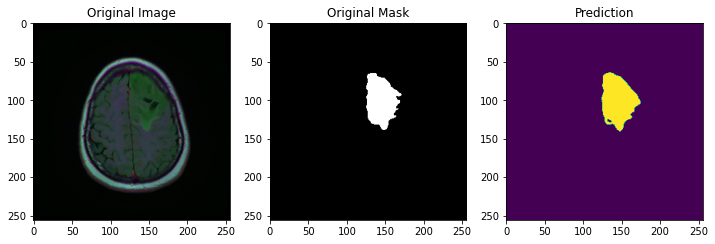

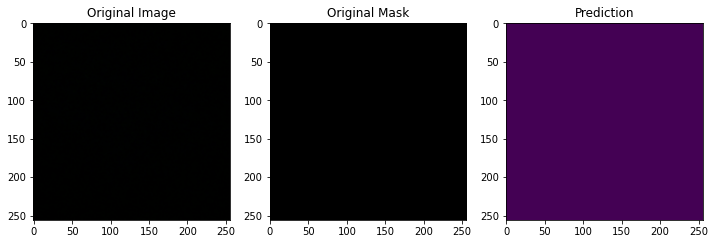

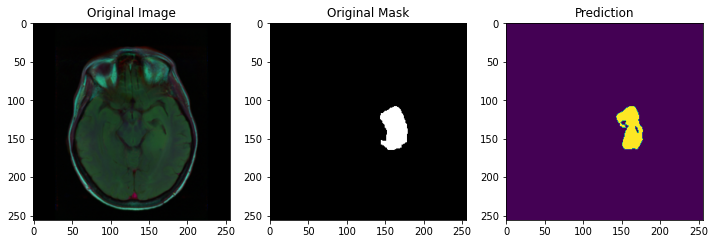

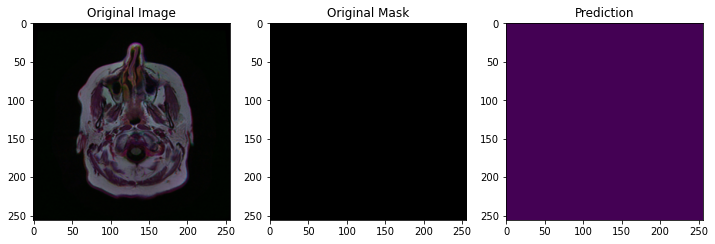

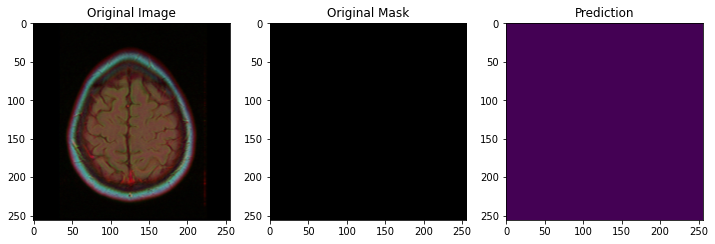

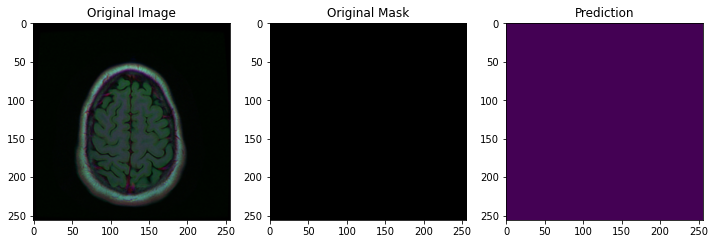

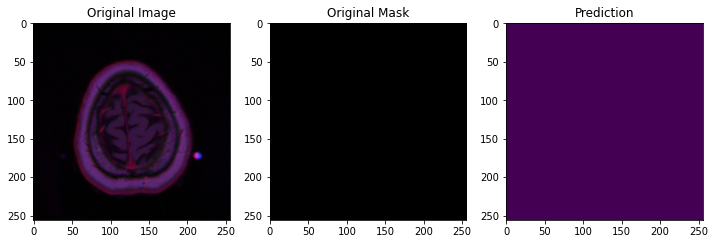

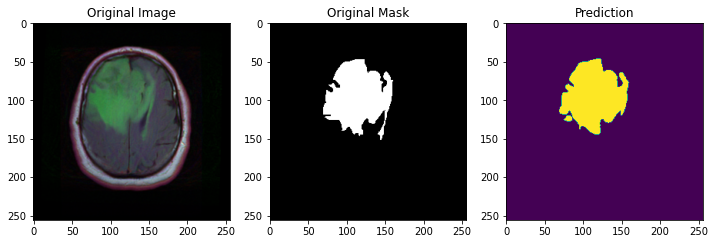

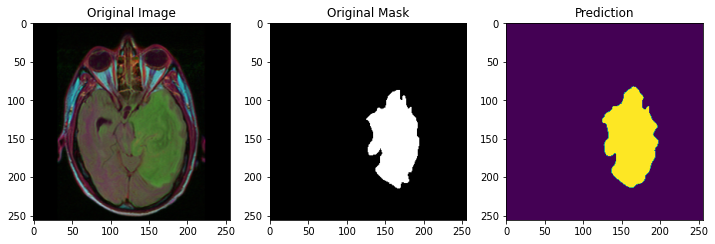

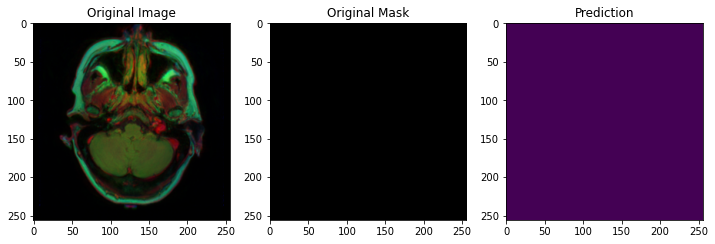

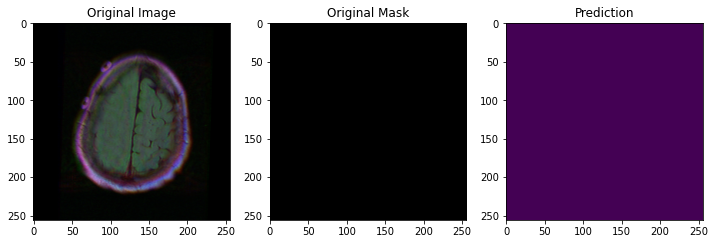

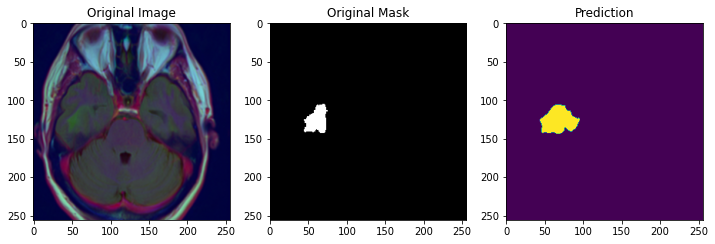

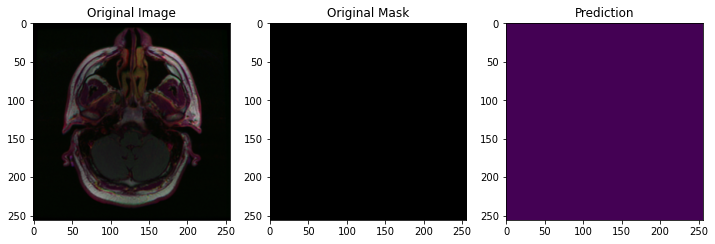

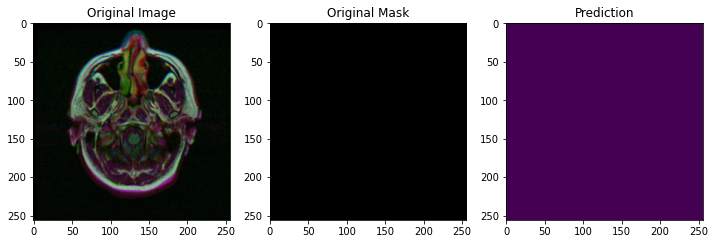

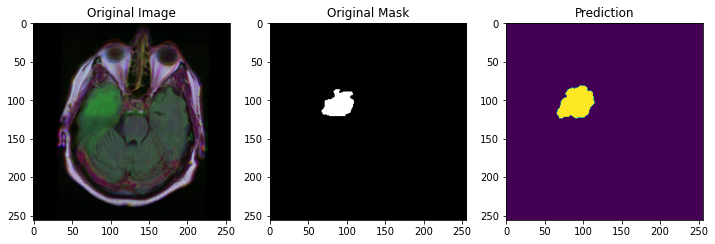

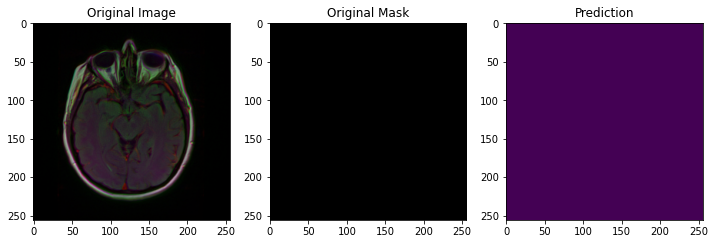

In [ ]:
for i in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filenames_train'].iloc[index])
    img = cv2.resize(img, (im_height, im_width))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model.predict(img)
    
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5 )
    plt.title('Prediction')
    plt.show()